In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter, defaultdict

# Set style for better visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load SQuAD Dataset

In [2]:
# Define paths
train_path = Path('../archive/train-v1.1.json')
dev_path = Path('../archive/dev-v1.1.json')

# Load training data
with open(train_path, 'r', encoding='utf-8') as f:
    train_data = json.load(f)

# Load development/validation data
with open(dev_path, 'r', encoding='utf-8') as f:
    dev_data = json.load(f)

print(f"✓ Loaded training data from {train_path}")
print(f"✓ Loaded dev data from {dev_path}")

✓ Loaded training data from ..\archive\train-v1.1.json
✓ Loaded dev data from ..\archive\dev-v1.1.json


## 2. Understand JSON Structure

In [3]:
# Examine top-level structure
print("Top-level keys:", train_data.keys())
print("\nDataset version:", train_data.get('version', 'N/A'))
print(f"Number of articles in training set: {len(train_data['data'])}")
print(f"Number of articles in dev set: {len(dev_data['data'])}")

Top-level keys: dict_keys(['data', 'version'])

Dataset version: 1.1
Number of articles in training set: 442
Number of articles in dev set: 48


In [4]:
# Examine first article structure
sample_article = train_data['data'][0]
print("Article title:", sample_article['title'])
print("\nNumber of paragraphs:", len(sample_article['paragraphs']))
print("\nFirst paragraph keys:", sample_article['paragraphs'][0].keys())

Article title: University_of_Notre_Dame

Number of paragraphs: 55

First paragraph keys: dict_keys(['context', 'qas'])


In [5]:
# Examine context and questions
sample_paragraph = sample_article['paragraphs'][0]
print("Context (first 200 chars):")
print(sample_paragraph['context'][:200], "...\n")

print(f"Number of questions for this context: {len(sample_paragraph['qas'])}")
print("\nFirst question example:")
sample_qa = sample_paragraph['qas'][0]
print(json.dumps(sample_qa, indent=2))

Context (first 200 chars):
Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper sta ...

Number of questions for this context: 5

First question example:
{
  "answers": [
    {
      "answer_start": 515,
      "text": "Saint Bernadette Soubirous"
    }
  ],
  "question": "To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?",
  "id": "5733be284776f41900661182"
}


## 3. Extract Dataset Statistics

In [6]:
def extract_statistics(data, dataset_name='Dataset'):
    """Extract comprehensive statistics from SQuAD data."""
    stats = {
        'num_articles': 0,
        'num_paragraphs': 0,
        'num_questions': 0,
        'context_lengths': [],
        'question_lengths': [],
        'answer_lengths': [],
        'answer_starts': [],
        'questions_per_context': [],
        'question_types': [],
        'article_titles': []
    }
    
    for article in data['data']:
        stats['num_articles'] += 1
        stats['article_titles'].append(article['title'])
        
        for paragraph in article['paragraphs']:
            stats['num_paragraphs'] += 1
            context = paragraph['context']
            stats['context_lengths'].append(len(context))
            
            num_questions = len(paragraph['qas'])
            stats['questions_per_context'].append(num_questions)
            
            for qa in paragraph['qas']:
                stats['num_questions'] += 1
                question = qa['question']
                stats['question_lengths'].append(len(question))
                
                # Extract question type (first word)
                first_word = question.split()[0].lower() if question else 'unknown'
                stats['question_types'].append(first_word)
                
                # Answer information
                if qa['answers']:
                    answer = qa['answers'][0]  # Use first answer
                    stats['answer_lengths'].append(len(answer['text']))
                    stats['answer_starts'].append(answer['answer_start'])
    
    # Print summary
    print(f"\n{'='*50}")
    print(f"{dataset_name} Statistics")
    print(f"{'='*50}")
    print(f"Total articles: {stats['num_articles']:,}")
    print(f"Total paragraphs: {stats['num_paragraphs']:,}")
    print(f"Total questions: {stats['num_questions']:,}")
    print(f"\nAverage questions per context: {np.mean(stats['questions_per_context']):.2f}")
    print(f"Average context length (chars): {np.mean(stats['context_lengths']):.0f}")
    print(f"Average question length (chars): {np.mean(stats['question_lengths']):.0f}")
    print(f"Average answer length (chars): {np.mean(stats['answer_lengths']):.0f}")
    
    return stats

# Extract statistics for both datasets
train_stats = extract_statistics(train_data, 'Training Set')
dev_stats = extract_statistics(dev_data, 'Development Set')


Training Set Statistics
Total articles: 442
Total paragraphs: 18,896
Total questions: 87,599

Average questions per context: 4.64
Average context length (chars): 736
Average question length (chars): 60
Average answer length (chars): 20

Development Set Statistics
Total articles: 48
Total paragraphs: 2,067
Total questions: 10,570

Average questions per context: 5.11
Average context length (chars): 774
Average question length (chars): 60
Average answer length (chars): 19


## 4. Visualize Dataset Distributions

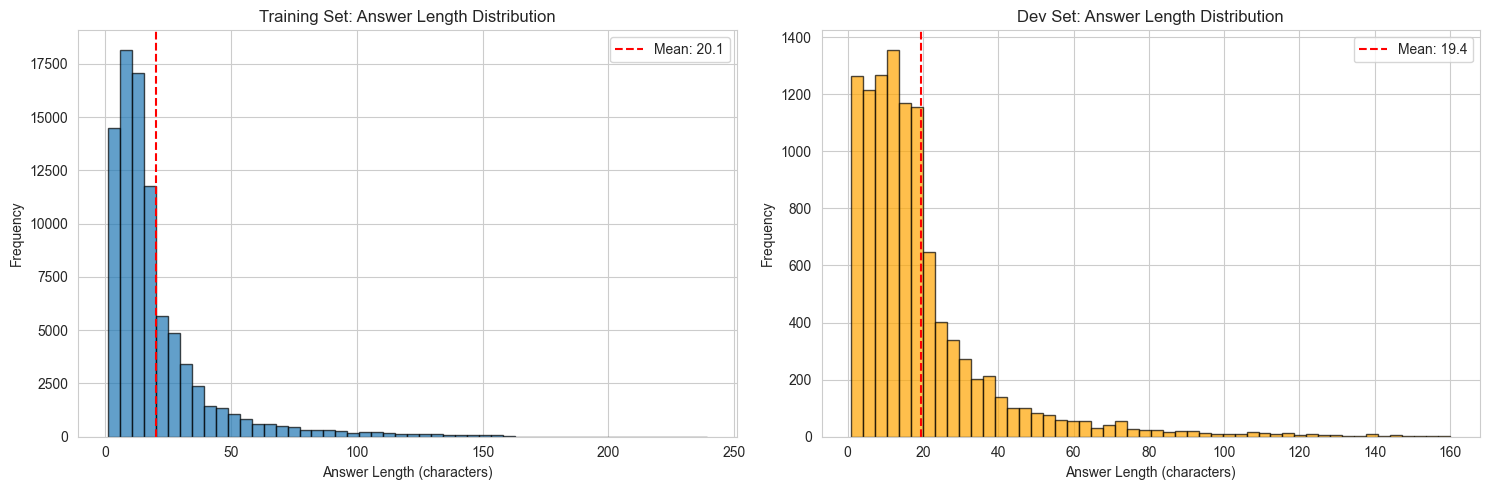

In [7]:
# Answer length distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(train_stats['answer_lengths'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Answer Length (characters)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Training Set: Answer Length Distribution')
axes[0].axvline(np.mean(train_stats['answer_lengths']), color='red', linestyle='--', 
                label=f'Mean: {np.mean(train_stats["answer_lengths"]):.1f}')
axes[0].legend()

axes[1].hist(dev_stats['answer_lengths'], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_xlabel('Answer Length (characters)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Dev Set: Answer Length Distribution')
axes[1].axvline(np.mean(dev_stats['answer_lengths']), color='red', linestyle='--',
                label=f'Mean: {np.mean(dev_stats["answer_lengths"]):.1f}')
axes[1].legend()

plt.tight_layout()
plt.show()

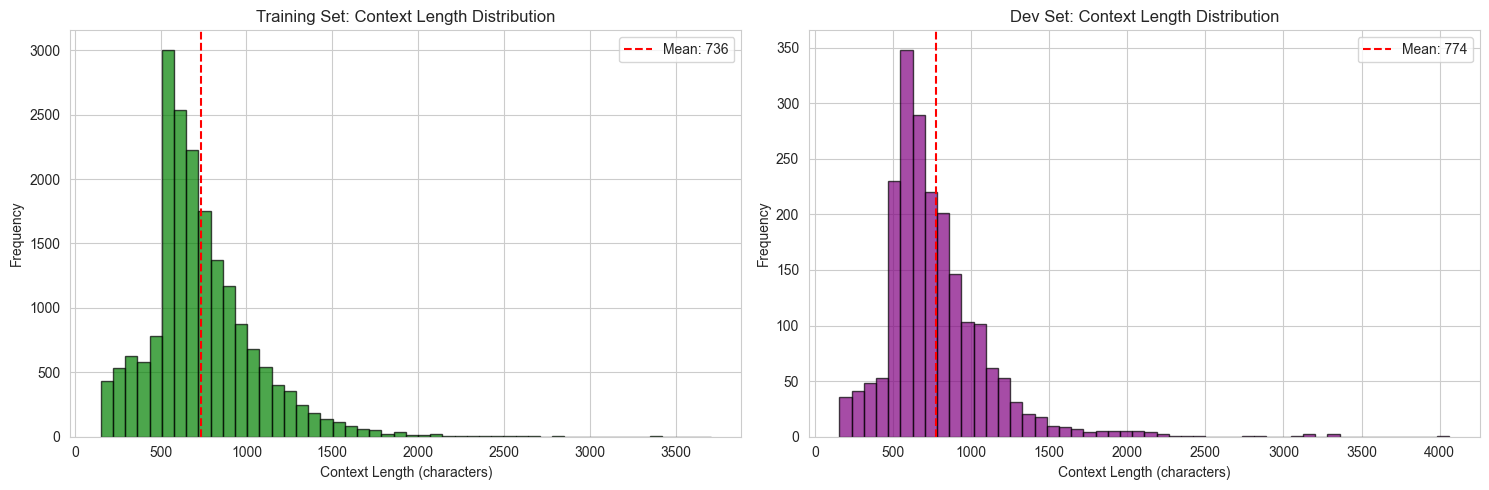

In [8]:
# Context length distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(train_stats['context_lengths'], bins=50, edgecolor='black', alpha=0.7, color='green')
axes[0].set_xlabel('Context Length (characters)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Training Set: Context Length Distribution')
axes[0].axvline(np.mean(train_stats['context_lengths']), color='red', linestyle='--',
                label=f'Mean: {np.mean(train_stats["context_lengths"]):.0f}')
axes[0].legend()

axes[1].hist(dev_stats['context_lengths'], bins=50, edgecolor='black', alpha=0.7, color='purple')
axes[1].set_xlabel('Context Length (characters)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Dev Set: Context Length Distribution')
axes[1].axvline(np.mean(dev_stats['context_lengths']), color='red', linestyle='--',
                label=f'Mean: {np.mean(dev_stats["context_lengths"]):.0f}')
axes[1].legend()

plt.tight_layout()
plt.show()

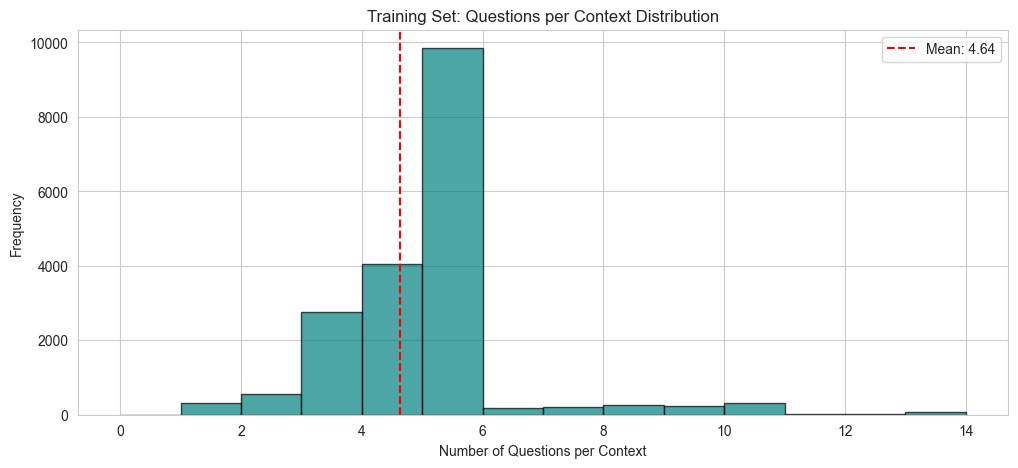

In [9]:
# Questions per context distribution
plt.figure(figsize=(12, 5))
plt.hist(train_stats['questions_per_context'], bins=range(0, 15), 
         edgecolor='black', alpha=0.7, color='teal')
plt.xlabel('Number of Questions per Context')
plt.ylabel('Frequency')
plt.title('Training Set: Questions per Context Distribution')
plt.axvline(np.mean(train_stats['questions_per_context']), color='red', linestyle='--',
            label=f'Mean: {np.mean(train_stats["questions_per_context"]):.2f}')
plt.legend()
plt.show()

## 5. Question Type Analysis

In [10]:
# Count question types
train_question_types = Counter(train_stats['question_types'])
dev_question_types = Counter(dev_stats['question_types'])

# Get top 10 question types
top_question_types = train_question_types.most_common(10)

print("Top 10 Question Types in Training Set:")
print("-" * 40)
for qtype, count in top_question_types:
    percentage = (count / train_stats['num_questions']) * 100
    print(f"{qtype.capitalize():15s} {count:6,} ({percentage:5.2f}%)")

Top 10 Question Types in Training Set:
----------------------------------------
What            37,593 (42.91%)
Who              8,150 ( 9.30%)
How              8,124 ( 9.27%)
When             5,459 ( 6.23%)
In               4,352 ( 4.97%)
Which            4,159 ( 4.75%)
Where            3,291 ( 3.76%)
The              2,318 ( 2.65%)
Why              1,201 ( 1.37%)
On                 590 ( 0.67%)


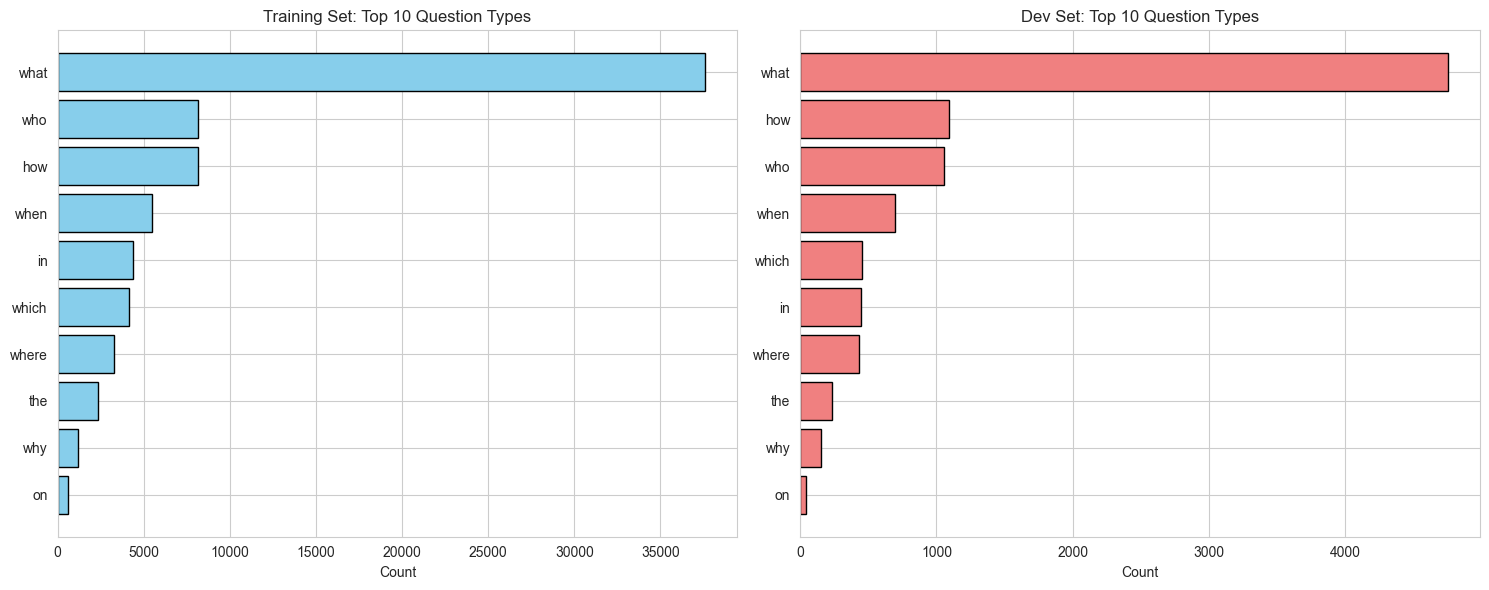

In [11]:
# Visualize question types
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Training set
types, counts = zip(*train_question_types.most_common(10))
axes[0].barh(types, counts, color='skyblue', edgecolor='black')
axes[0].set_xlabel('Count')
axes[0].set_title('Training Set: Top 10 Question Types')
axes[0].invert_yaxis()

# Dev set
types_dev, counts_dev = zip(*dev_question_types.most_common(10))
axes[1].barh(types_dev, counts_dev, color='lightcoral', edgecolor='black')
axes[1].set_xlabel('Count')
axes[1].set_title('Dev Set: Top 10 Question Types')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

## 6. Sample Article Topics

In [12]:
# Display sample article titles
print("Sample Article Titles from Training Set:")
print("=" * 50)
for i, title in enumerate(train_stats['article_titles'][:20], 1):
    print(f"{i:2d}. {title}")

Sample Article Titles from Training Set:
 1. University_of_Notre_Dame
 2. Beyoncé
 3. Montana
 4. Genocide
 5. Antibiotics
 6. Frédéric_Chopin
 7. Sino-Tibetan_relations_during_the_Ming_dynasty
 8. IPod
 9. The_Legend_of_Zelda:_Twilight_Princess
10. Spectre_(2015_film)
11. 2008_Sichuan_earthquake
12. New_York_City
13. To_Kill_a_Mockingbird
14. Solar_energy
15. Tajikistan
16. Anthropology
17. Portugal
18. Kanye_West
19. Buddhism
20. American_Idol


## 7. Create Summary DataFrame

In [13]:
# Create summary comparison
summary_df = pd.DataFrame({
    'Metric': [
        'Articles',
        'Paragraphs',
        'Questions',
        'Avg Questions/Context',
        'Avg Context Length (chars)',
        'Avg Question Length (chars)',
        'Avg Answer Length (chars)',
        'Max Answer Length (chars)',
        'Min Answer Length (chars)'
    ],
    'Training Set': [
        f"{train_stats['num_articles']:,}",
        f"{train_stats['num_paragraphs']:,}",
        f"{train_stats['num_questions']:,}",
        f"{np.mean(train_stats['questions_per_context']):.2f}",
        f"{np.mean(train_stats['context_lengths']):.0f}",
        f"{np.mean(train_stats['question_lengths']):.0f}",
        f"{np.mean(train_stats['answer_lengths']):.0f}",
        f"{max(train_stats['answer_lengths'])}",
        f"{min(train_stats['answer_lengths'])}"
    ],
    'Dev Set': [
        f"{dev_stats['num_articles']:,}",
        f"{dev_stats['num_paragraphs']:,}",
        f"{dev_stats['num_questions']:,}",
        f"{np.mean(dev_stats['questions_per_context']):.2f}",
        f"{np.mean(dev_stats['context_lengths']):.0f}",
        f"{np.mean(dev_stats['question_lengths']):.0f}",
        f"{np.mean(dev_stats['answer_lengths']):.0f}",
        f"{max(dev_stats['answer_lengths'])}",
        f"{min(dev_stats['answer_lengths'])}"
    ]
})

print("\n" + "="*60)
print("SQuAD v1.1 Dataset Summary")
print("="*60)
print(summary_df.to_string(index=False))


SQuAD v1.1 Dataset Summary
                     Metric Training Set Dev Set
                   Articles          442      48
                 Paragraphs       18,896   2,067
                  Questions       87,599  10,570
      Avg Questions/Context         4.64    5.11
 Avg Context Length (chars)          736     774
Avg Question Length (chars)           60      60
  Avg Answer Length (chars)           20      19
  Max Answer Length (chars)          239     160
  Min Answer Length (chars)            1       1
                     Metric Training Set Dev Set
                   Articles          442      48
                 Paragraphs       18,896   2,067
                  Questions       87,599  10,570
      Avg Questions/Context         4.64    5.11
 Avg Context Length (chars)          736     774
Avg Question Length (chars)           60      60
  Avg Answer Length (chars)           20      19
  Max Answer Length (chars)          239     160
  Min Answer Length (chars)            1 

## 8. Sample Question-Answer Pairs

In [14]:
# Display sample QA pairs
def display_sample_qa(data, num_samples=3):
    """Display sample question-answer pairs with context."""
    samples_shown = 0
    
    for article in data['data']:
        if samples_shown >= num_samples:
            break
            
        for paragraph in article['paragraphs']:
            if samples_shown >= num_samples:
                break
                
            context = paragraph['context']
            qa = paragraph['qas'][0] if paragraph['qas'] else None
            
            if qa and qa['answers']:
                answer = qa['answers'][0]
                samples_shown += 1
                
                print(f"\n{'='*80}")
                print(f"Sample {samples_shown}: {article['title']}")
                print(f"{'='*80}")
                print(f"\nContext:\n{context[:300]}..." if len(context) > 300 else f"\nContext:\n{context}")
                print(f"\nQuestion: {qa['question']}")
                print(f"\nAnswer: {answer['text']}")
                print(f"Answer starts at character position: {answer['answer_start']}")

display_sample_qa(train_data, num_samples=3)


Sample 1: University_of_Notre_Dame

Context:
Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is ...

Question: To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?

Answer: Saint Bernadette Soubirous
Answer starts at character position: 515

Sample 2: University_of_Notre_Dame

Context:
As at most other universities, Notre Dame's students run a number of news media outlets. The nine student-run outlets include three newspapers, both a radio and television station, and several magazines and journals. Begun as a one-page journal in September 1876, the Scholastic magazine is issued tw...

Question: When did the Scholastic Magazine of Notre dame begin publishing?

Answer: September 1876
Answer starts at character position: 248

## Summary

### Key Findings:
1. **Dataset Size**: ~87k training questions, ~10k dev questions
2. **Question Types**: Dominated by "what", "who", "when", "how" questions
3. **Answer Format**: Short extractive spans (average ~15-20 characters)
4. **Context Length**: Varies widely but averages ~600-800 characters
5. **Questions per Context**: Typically 3-5 questions per paragraph

### Next Steps:
- Tokenize questions and contexts using BERT tokenizer
- Map character-level answer positions to token positions
- Build PyTorch Dataset and DataLoader
- Fine-tune BERT for question answering